<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Combining-all-antismash-GBKs" data-toc-modified-id="Combining-all-antismash-GBKs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combining all antismash GBKs</a></span><ul class="toc-item"><li><span><a href="#Writing-table-of-BGC-IDs" data-toc-modified-id="Writing-table-of-BGC-IDs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Writing table of BGC IDs</a></span></li></ul></li><li><span><a href="#BiGSCAPE" data-toc-modified-id="BiGSCAPE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>BiGSCAPE</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Summarize" data-toc-modified-id="Summarize-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Summarize</a></span></li><li><span><a href="#Writing-fam-clan-table" data-toc-modified-id="Writing-fam-clan-table-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Writing fam-clan table</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Run `BiGSCAPE` on all BGCs identified by `antismash`

# Var

In [13]:
# Dereplicated MAGs
MAG_dir = file.path('/ebio', 'abt3_projects', 'Georg_animal_feces', 'data',
                     'metagenome', 'multi-study', 'BioProjects', 'summary',
                     'LLMGA', 'wGeorgAnimal', 'drep-0.95')

# de-rep'd MAG metadata
MAG_meta_file = file.path(MAG_dir, 'drep-MAG_metadata.tsv')

# antismash dir
antismash_dir = file.path(MAG_dir, 'BGCs', 'antismash_v5')

# working dir
work_dir = file.path(MAG_dir, 'BGCs', 'bigscape')

# pfam dir (hmms)
pfam_dir = '/ebio/abt3_projects/databases_no-backup/pfam/v32.0/'

# table of BGC UUIDs
BGC_uuid_file = file.path(antismash_dir, 'BGC_uuids.tsv')

# BGC metadata
BGC_meta_file = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/BGC_product_summary.tsv'

# params
conda_env = 'bigscape'
threads = 24

# Init

In [4]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(doParallel)
library(LeyLabRMisc)

library(future)
library(future.batchtools)
library(future.apply)
options(future.wait.interval = 2.0)

In [5]:
df.dims()
set.seed(7834)
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape 


# Combining all antismash GBKs

In [24]:
antismash_gbk_dir = file.path(work_dir, 'antismash_gbks')
make_dir(antismash_gbk_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/antismash_gbks 


In [25]:
# listing all antismash gbk files
## WARNING: a bit slow
gbk_files = list.files(antismash_dir, '*.gbk', full.names=TRUE, recursive=TRUE)
gbk_files = gbk_files[grepl('.+\\.\\.\\.region[0-9]+\\.gbk$', gbk_files)]
gbk_files %>% length %>% print

[1] 1953


In [26]:
# creating an index of file names
gbk_files = data.frame(MAG = basename(dirname(gbk_files)),
                       gbk_file = gbk_files)
gbk_files 

MAG,gbk_file
<fct>,<fct>
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00016_artific...region001.gbk
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00086_artific...region001.gbk
⋮,⋮
X95_Meadow_Viper__metabat2_low_PE_002,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X95_Meadow_Viper__metabat2_low_PE_002/c00181_X95_Mea...region001.gbk
X96_European_Hare__metabat2_high_PE_013,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X96_European_Hare__metabat2_high_PE_013/c00008_X96_Eur...region001.gbk


In [27]:
# joining with existing UUIDs
gbk_files = gbk_files %>%
    inner_join(read.delim(BGC_uuid_file, sep='\t'),
               by=c('MAG', 'gbk_file'))
gbk_files

MAG,gbk_file,BGC_ID
<fct>,<fct>,<fct>
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00016_artific...region001.gbk,BGC-616e4b101d0811ea80fbacde48b9eeb0
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00086_artific...region001.gbk,BGC-762e4883c90a474a88ad3e43eac6529e
⋮,⋮,⋮
X95_Meadow_Viper__metabat2_low_PE_002,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X95_Meadow_Viper__metabat2_low_PE_002/c00181_X95_Mea...region001.gbk,BGC-8ad0a79939384249b230479191948b48
X96_European_Hare__metabat2_high_PE_013,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X96_European_Hare__metabat2_high_PE_013/c00008_X96_Eur...region001.gbk,BGC-d05a324fb73543649b9ab73d32b16b31


In [28]:
# # creating unique BGC IDs
# ## WARNING: this is dependent on set.seed
# gbk_files$BGC_ID = sapply(1:nrow(gbk_files), uuid) %>%
#    gsub('-', '', .) %>%
#    gsub('^', 'BGC-', .) 

# gbk_files 

In [29]:
# creating output file names
gbk_files = gbk_files %>%
    mutate(X = antismash_gbk_dir,
           Y = gsub('$', '.gbk', BGC_ID)) %>%
    unite(out_file, X, Y, sep='/') 

gbk_files

MAG,gbk_file,BGC_ID,out_file
<fct>,<fct>,<fct>,<chr>
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00016_artific...region001.gbk,BGC-616e4b101d0811ea80fbacde48b9eeb0,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/antismash_gbks/BGC-616e4b101d0811ea80fbacde48b9eeb0.gbk
artificially_reared_2__maxbin2_low_prob_006,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/artificially_reared_2__maxbin2_low_prob_006/c00086_artific...region001.gbk,BGC-762e4883c90a474a88ad3e43eac6529e,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/antismash_gbks/BGC-762e4883c90a474a88ad3e43eac6529e.gbk
⋮,⋮,⋮,⋮
X95_Meadow_Viper__metabat2_low_PE_002,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X95_Meadow_Viper__metabat2_low_PE_002/c00181_X95_Mea...region001.gbk,BGC-8ad0a79939384249b230479191948b48,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/antismash_gbks/BGC-8ad0a79939384249b230479191948b48.gbk
X96_European_Hare__metabat2_high_PE_013,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X96_European_Hare__metabat2_high_PE_013/c00008_X96_Eur...region001.gbk,BGC-d05a324fb73543649b9ab73d32b16b31,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/antismash_gbks/BGC-d05a324fb73543649b9ab73d32b16b31.gbk


In [26]:
# copying files
cp_file = function(in_file, out_file){
    if(out_file == in_file){
        stop('output == input')
    }
    file.copy(in_file, out_file, overwrite = TRUE)
}

ret = mapply(cp_file, 
             in_file=gbk_files$gbk_file %>% as.character, 
             out_file=gbk_files$out_file %>% as.character)
ret %>% length

[1] 1953

In [27]:
# checking number of files
list.files(antismash_gbk_dir, '*.gbk') %>% length %>% print

[1] 1953


## Writing table of BGC IDs

In [ ]:
# WARNING: not needed unless changing 
BGC_id_file = file.path(antismash_dir, 'BGC_uuids.tsv')
gbk_files %>%
    dplyr::select(BGC_ID, MAG, gbk_file) %>%
    write.table(file=BGC_id_file, sep='\t', quote=FALSE, row.names=FALSE)
cat('File written:', BGC_id_file, '\n')

# BiGSCAPE

In [ ]:
exe = '/ebio/abt3_projects/Georg_animal_feces/bin/BiG-SCAPE/bigscape.py'
cmd = '{exe} -i {in_dir} -o {out_dir} --pfam_dir {pfam_dir} --cores {threads} --mibig --include_gbk_str \"*\"'
cmd = glue::glue(cmd, exe=exe,
                 in_dir=antismash_gbk_dir, 
                 out_dir=work_dir, pfam_dir=pfam_dir,
                 threads=threads)
cmd

In [ ]:
bash_job(cmd, conda_env=conda_env, stderr=TRUE)

# Summary

In [77]:
cat('Output:', work_dir, '\n')

Output: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape 


In [ ]:
list.files(file.path(work_dir, 'html_content'))

## Load

In [19]:
# Loading all clan files
clan_files = list.files(file.path(work_dir, 'network_files'), 
           pattern='*_clans_0.30_0.70.tsv',
           recursive=TRUE, full.names=TRUE)

clan_files %>% length

[1] 8

In [20]:
#' function to merge clans
merge_clans = function(F){
    df = read.delim(F, sep='\t')
    df$BGC_type = F %>% dirname %>% basename
    return(df)
}

clans = clan_files %>% 
    as.list %>%
    lapply(merge_clans) %>%
    do.call(rbind, .) %>%
    mutate(MAG_BGC = grepl('^BGC-', X.BGC.Name))

# status
clans$X.BGC.Name %>% length
clans$X.BGC.Name %>% unique %>% length
clans$BGC_type %>% table
clans$MAG_BGC %>% table
clans

[1] 1995

[1] 1964

.
           NRPS          Others PKS-NRP_Hybrids            PKSI        PKSother 
            661             513               9              31              93 
          RiPPs     Saccharides         Terpene 
            565               2             121 

.
FALSE  TRUE 
   14  1981 

X.BGC.Name,Clan.Number,Family.Number,BGC_type,MAG_BGC
<fct>,<int>,<int>,<chr>,<lgl>
BGC-0005d06b1fd5420cbb1ba1f265ea1f71,0,0,NRPS,TRUE
BGC-006c4606d91f4793907ca48884886cf7,5,5,NRPS,TRUE
⋮,⋮,⋮,⋮,⋮
BGC-c8ed898714b84aa4ab4e38788299d8ce,1527,1527,Terpene,TRUE
BGC-41d3a752a38445b39f4a0cc94e9c8335,508,508,Terpene,TRUE


In [21]:
# numbers of clans & families
cat('No. of clans:', clans %>%
    filter(MAG_BGC == TRUE) %>%
    .$Clan.Number %>% unique %>% length, '\n')
cat('No. of families:', clans %>%
    filter(MAG_BGC == TRUE) %>%
    .$Family.Number %>% unique %>% length, '\n')

No. of clans: 1305 
No. of families: 1764 


In [31]:
clans = clans %>%
    left_join(gbk_files %>% dplyr::select(-out_file), 
               by=c('X.BGC.Name'='BGC_ID'))
clans

Warning message:
“Column `X.BGC.Name`/`BGC_ID` joining character vector and factor, coercing into character vector”


X.BGC.Name,Clan.Number,Family.Number,BGC_type,MAG_BGC,MAG.x,MAG.y,gbk_file
<chr>,<int>,<int>,<chr>,<lgl>,<fct>,<fct>,<fct>
BGC-0005d06b1fd5420cbb1ba1f265ea1f71,0,0,NRPS,TRUE,SAMEA104315434__metabat2_high_PE_014,SAMEA104315434__metabat2_high_PE_014,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/SAMEA104315434__metabat2_high_PE_014/c00038_SAMEA10...region001.gbk
BGC-006c4606d91f4793907ca48884886cf7,5,5,NRPS,TRUE,R04__metabat2_low_PE_045,R04__metabat2_low_PE_045,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/R04__metabat2_low_PE_045/c00311_R04__co...region001.gbk
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
BGC-c8ed898714b84aa4ab4e38788299d8ce,1527,1527,Terpene,TRUE,X190_Common_House_Gecko__metabat2_low_PE_001,X190_Common_House_Gecko__metabat2_low_PE_001,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/X190_Common_House_Gecko__metabat2_low_PE_001/c00208_X190_Co...region001.gbk
BGC-41d3a752a38445b39f4a0cc94e9c8335,508,508,Terpene,TRUE,Garnier_p2__metabat2_high_PE_037,Garnier_p2__metabat2_high_PE_037,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/antismash_v5/Garnier_p2__metabat2_high_PE_037/c00010_Garnier...region001.gbk


In [44]:
# adding BGC metadata & writing table
BGC_summary_file = file.path(work_dir, 'BGC-BiGSCAPE_summary.tsv')
BGC_meta = read.delim(BGC_meta_file, sep='\t')
BGC_meta %>%
    left_join(clans, c('gbk_file')) %>%
    distinct(product, gbk_file, X.BGC.Name, .keep_all=TRUE) %>%
    dplyr::select(genome_ID, product, Clan.Number, Family.Number, BGC_type) %>%
    write_table(BGC_summary_file)

File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/BGC-BiGSCAPE_summary.tsv 


## Summarize

In [38]:
# BGC distribution
dt.dims(40)
clans %>%
    group_by(BGC_type, MAG_BGC) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    arrange(MAG_BGC)

BGC_type,MAG_BGC,n
<chr>,<lgl>,<int>
NRPS,FALSE,2
Others,FALSE,1
PKS-NRP_Hybrids,FALSE,1
PKSother,FALSE,6
RiPPs,FALSE,3
Terpene,FALSE,1
NRPS,TRUE,659
Others,TRUE,512
PKS-NRP_Hybrids,TRUE,8


In [39]:
# MAG-BGCs assocated with a known BGC
fam_wRef = clans %>%
    filter(MAG_BGC == FALSE) %>%
    .$Family.Number

cat('Families with a ref BGC:', fam_wRef %>% unique %>% length, '\n')

# which MAGs BGCs?
clans %>%
    filter(Family.Number %in% fam_wRef,
           MAG_BGC == TRUE) %>%
    group_by(BGC_type) %>%
    summarize(n = n()) %>%
    ungroup()

Families with a ref BGC: 8 


BGC_type,n
<chr>,<int>
NRPS,2
Others,1
PKS-NRP_Hybrids,1
PKSother,3
RiPPs,1
Terpene,1


In [84]:
# MAG-BGCs assocated with a known BGC
clan_wRef = clans %>%
    filter(MAG_BGC == FALSE) %>%
    .$Clan.Number

cat('Clans with a ref BGC:', clan_wRef %>% unique %>% length, '\n')

Clans with a ref BGC: 8 


In [50]:
# adding ref info
clans = clans %>%
    mutate(BGC_fam_has_ref = Family.Number %in% fam_wRef) 
clans

X.BGC.Name,Clan.Number,Family.Number,BGC_type,MAG_BGC,MAG,BGC_fam_has_ref
<chr>,<int>,<int>,<chr>,<lgl>,<fct>,<lgl>
BGC-0005d06b1fd5420cbb1ba1f265ea1f71,0,0,NRPS,TRUE,SAMEA104315434__metabat2_high_PE_014,FALSE
BGC-006c4606d91f4793907ca48884886cf7,5,5,NRPS,TRUE,R04__metabat2_low_PE_045,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
BGC-c8ed898714b84aa4ab4e38788299d8ce,1527,1527,Terpene,TRUE,X190_Common_House_Gecko__metabat2_low_PE_001,FALSE
BGC-41d3a752a38445b39f4a0cc94e9c8335,508,508,Terpene,TRUE,Garnier_p2__metabat2_high_PE_037,FALSE


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/metagenome/multi-study/08_drep95_wGeorgAnimal/.figures/22cb94045580c60f151b253111eef6b8.RDS 


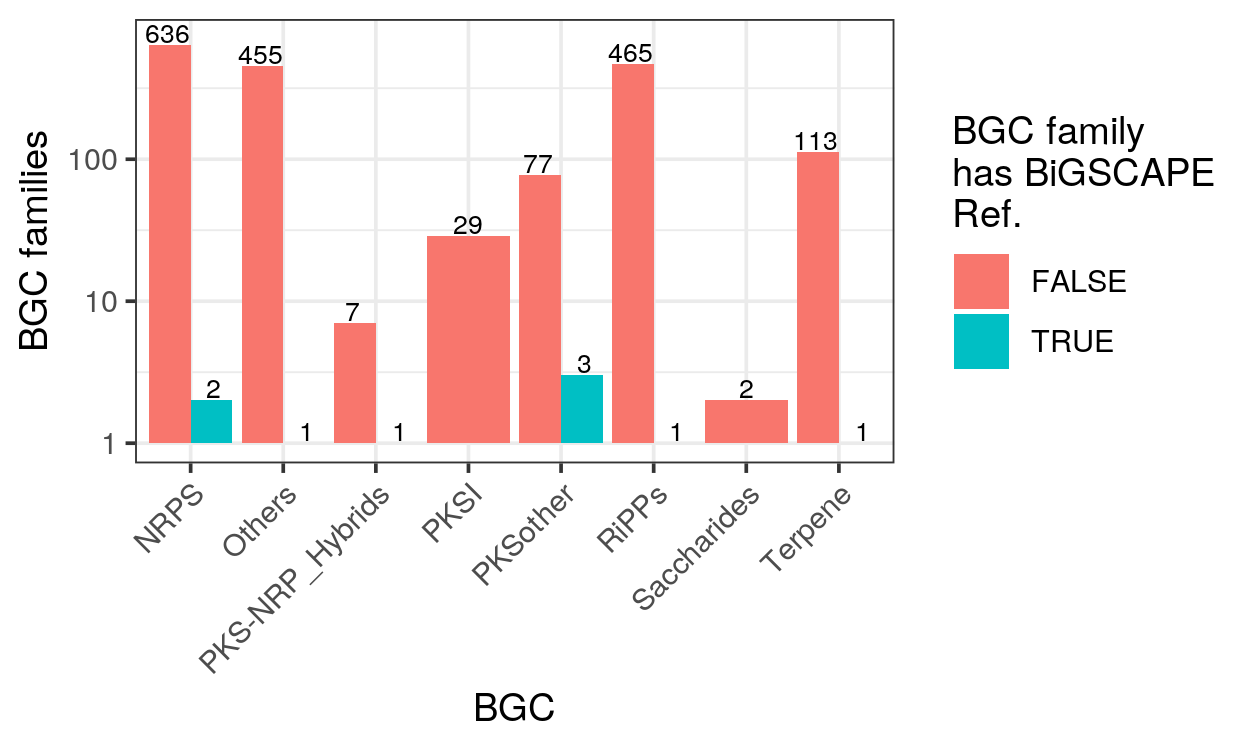

In [76]:
# fraction in gene fam with ref
clans_s = clans %>%
    group_by(BGC_type, BGC_fam_has_ref) %>%
    summarize(n = n_distinct(Family.Number)) %>%
    ungroup() 

p = clans_s %>%
    ggplot(aes(BGC_type, n, fill=BGC_fam_has_ref)) +
    geom_bar(stat='identity', position='dodge') +
    geom_text(aes(label=n),
              position = position_dodge(width = 1),
              vjust=-0.1, size=2.7) +
    scale_y_log10(limits=c(1,700)) +
    scale_fill_discrete('BGC family\nhas BiGSCAPE\nRef.') +
    labs(x='BGC', y='BGC families') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

dims(5,3,res=250)
Plot(p)

In [55]:
dt.dims(40)
clans_s %>%
    mutate(BGC_fam_has_ref = ifelse(BGC_fam_has_ref == TRUE, 'Ref', 'NoRef')) %>%
    spread(BGC_fam_has_ref, n) %>%
    mutate(perc_fams_w_ref = round(Ref / (Ref + NoRef) * 100,1)) %>%
    rename('BGC' = BGC_type,
           'No BiGSCAPE ref.' =  NoRef,
           'BiGSCAPE ref.' =  Ref,
           'Perc. with ref.' = perc_fams_w_ref) %>%
    arrange(-`Perc. with ref.`) 

BGC,No BiGSCAPE ref.,BiGSCAPE ref.,Perc. with ref.
<chr>,<int>,<int>,<dbl>
PKS-NRP_Hybrids,7,1,12.5
PKSother,77,3,3.8
Terpene,113,1,0.9
NRPS,636,2,0.3
Others,455,1,0.2
RiPPs,465,1,0.2
PKSI,29,NA,NA
Saccharides,2,NA,NA


## Writing fam-clan table

In [56]:
outfile = file.path(work_dir, 'bigscape_fam-clan.tsv')
write_table(clans, outfile)

File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/BioProjects/summary/LLMGA/wGeorgAnimal/drep-0.95/BGCs/bigscape/bigscape_fam-clan.tsv

# sessionInfo

In [43]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/tidyverse/lib/libopenblasp-r0.3.7.so

Random number generation:
 RNG:     Mersenne-Twister 
 Normal:  Inversion 
 Sample:  Rounding 
 
locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future.apply_1.4.0      future.batchtools_0.8.1 future_1.15.1          
 [4] doParallel_1.0.15       iterators_1.0.12        foreach_1.4.7          
 [7] data.table_1

In [44]:
condaInfo(conda_env)

Could not find conda environment: bigscape
You can list all discoverable environments with `conda info --envs`.

# packages in environment at /ebio/abt3_projects/software/miniconda3_gt4.4:
#
# Name                    Version                   Build  Channel
_r-mutex                  1.0.1               anacondar_1    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
asn1crypto                0.24.0                     py_1    conda-forge
attrs                     19.3.0                     py_0    conda-forge
automat                   0.7.0                    py36_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
binutils_impl_linux-64    2.33.1               he1b5a44_7    conda-forge
binutils_linux-64         2.33.1              h9595d00_15    conda-forge
biopython                 1.73                     pypi_0    pypi
blas                      1.0                         mkl  
bleach                    3.1.0 